# Continual Fine-tuning (CFT)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Finetuning/Continual_Finetuning.ipynb)

<img src="../images/cft.png" width="950">

## Introduction to Continual Fine-tuning

Continual Fine-tuning (CFT) is a training approach where a model is sequentially fine-tuned on multiple datasets over time. Unlike traditional fine-tuning that treats each training run as independent, CFT builds upon previous training iterations by using model checkpoints from earlier fine-tuning sessions.

### Key Benefits of CFT:
- **Efficient learning**: The model retains knowledge from previous training while acquiring new capabilities
- **Iterative improvement**: Models can be enhanced incrementally with new data or skills
- **Reduced catastrophic forgetting**: By building on previous checkpoints, the model is less likely to lose earlier learned abilities

In this notebook, we demonstrate CFT with function calling capabilities by:
1. Fine-tuning a base model on a subset of function calling data
2. Continuing to train that model on additional function calling scenarios
3. Comparing different fine-tuning approaches.

#### Setup and Installation
---
First, install the necessary Python libraries. We need:
- `together`: The official Together AI Python client for interacting with the API (finetuning, inference, files, etc.).
- `datasets`: A library from Hugging Face for easily downloading and manipulating datasets.
- `matplotlib`: For data visualization

In [1]:
!pip install -qU together datasets matplotlib

In [2]:
from datasets import load_dataset
import json
from collections import Counter
import matplotlib.pyplot as plt

## Dataset Preparation

For our continual fine-tuning demonstration, we'll use the NousResearch's Hermes Function Calling dataset. This dataset contains conversations specially formatted to train models on function calling capabilities across various domains.

Let's load the dataset and examine its category distribution:

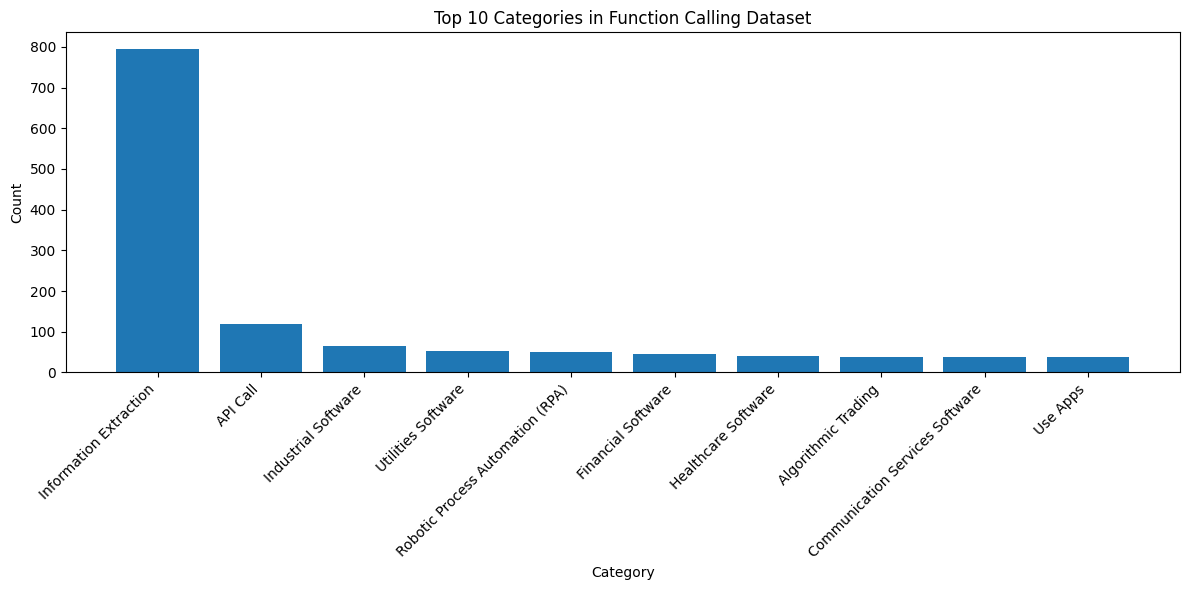

In [3]:
dataset_name = "NousResearch/hermes-function-calling-v1"
function_calling = load_dataset(dataset_name)

# Count categories
category_counts = Counter(function_calling["train"]["category"])

# Get top 10 categories
top_categories = category_counts.most_common(10)
categories, counts = zip(*top_categories)

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Categories in Function Calling Dataset')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Splitting the Dataset for Continual Learning

To demonstrate continual fine-tuning, we'll split our dataset into two parts:

1. **First training step**: We'll use specific categories related to common API calls, business software, and industry-specific applications. These are the top 8 most numerous data categories.
2. **Second training step**: We'll use the remaining categories to build upon our initial model. These are the remaining categories of data from the function calling dataset.

This simulates a real-world scenario where you might first only want to train a model on core functionalities, then expand its capabilities with more specialized data to niche domains.


In [4]:
first_step_categories = [
    "API Call",
    "Information Extraction",
    'Industrial Software',
    'Utilities Software',
    'Robotic Process Automation (RPA)',
    'Financial Software',
    'Healthcare Software',
    'Algorithmic Trading',
]

first_step_train = function_calling["train"].filter(lambda x: x["category"] in first_step_categories)
second_step_train = function_calling["train"].filter(lambda x: x["category"] not in first_step_categories)

### Data Formatting for Together AI

Together AI expects fine-tuning data in a specific JSONL format with messages using the `system`, `user`, and `assistant` roles. We need to convert our dataset to this format.

Each line in our output files will contain a complete conversation with all messages properly formatted. We'll create two separate files for our two training steps:

In [5]:
map_from = {"system": "system", "human": "user", "gpt": "assistant"}

with open("function_calling_1.jsonl", "w") as pfile:
    for line in first_step_train:
        conversations = line["conversations"]
        pfile.write(json.dumps(
            {"messages": [{"role": map_from[m["from"]], "content": m["value"] } for m in conversations]}
        ) + "\n")


with open("function_calling_2.jsonl", "w") as pfile:
    for line in second_step_train:
        conversations = line["conversations"]
        pfile.write(json.dumps(
            {"messages": [{"role": map_from[m["from"]], "content": m["value"] } for m in conversations]}
        ) + "\n")

### Together AI Setup

Now we'll initialize the Together AI client to access their fine-tuning API. You'll need to provide your API key to authenticate and access the service.


In [6]:
import os
from together import Together

TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
WANDB_API_KEY = os.getenv("WANDB_API_KEY") # needed for logging fine-tuning to wandb

client = Together(api_key=TOGETHER_API_KEY)

### Uploading Training Files

Before we can start fine-tuning, we need to upload our training files to the Together AI platform. The platform will process these files and make them available for fine-tuning jobs.

In [7]:
resp_fc1 = client.files.upload(file="function_calling_1.jsonl", check=True)
print(resp_fc1.id)

Uploading file function_calling_1.jsonl: 100%|██████████| 12.6M/12.6M [00:00<00:00, 13.5MB/s]


file-7100503d-8d7e-4714-8049-b44ddb3824c1


In [8]:
resp_fc2 = client.files.upload(file="function_calling_2.jsonl", check=True) # uploads a file
print(resp_fc2.id)

Uploading file function_calling_2.jsonl: 100%|██████████| 2.49M/2.49M [00:00<00:00, 5.41MB/s]


file-a4055a60-e1b3-48f2-a105-6eb2e3e7940b


## Fine-tuning Process

### Step 1: Initial Fine-tuning on Core Categories

We'll start by fine-tuning Llama-3.2-1B-Instruct on our first dataset containing core function calling categories. We're using LoRA (Low-Rank Adaptation), which is an efficient fine-tuning technique that updates only a small number of parameters, making the process faster and less resource-intensive.

Key parameters explained:
- `n_epochs`: Number of complete passes through the training dataset
- `n_checkpoints`: Number of model snapshots to save during training
- `batch_size`: Number of training examples processed together
- `lora`: Enables Low-Rank Adaptation for efficient fine-tuning
- `warmup_ratio`: Portion of training used to gradually increase learning rate

In [ ]:
ft_fc1 = client.fine_tuning.create(
    training_file = resp_fc1.id, # function_calling_1.jsonl
    model = 'meta-llama/Llama-3.2-1B-Instruct',
    n_epochs = 1,
    n_checkpoints = 1,
    batch_size = 16,
    lora=True,
    warmup_ratio=0.1,
    wandb_api_key=WANDB_API_KEY,
)

In [9]:
print(ft_fc1.id)

ft-09c05205-7ac5


### Step 2: Continual Fine-tuning - Building Upon Previous Training

Now for the key part of continual fine-tuning - we'll take the checkpoint from our first training run and continue training on the second dataset. This preserves the knowledge from the first training while expanding the model's capabilities with new function calling domains.

The critical parameter here is `from_checkpoint`, which tells Together AI to use our previous fine-tuning job as the starting point for this training run instead of starting from the base model again.

In [ ]:
ft_fc2 = client.fine_tuning.create(
    training_file = resp_fc2.id, # function_calling_2.jsonl
    from_checkpoint = ft_fc1.id, # "id" from the first run above 
    n_epochs = 1,
    n_checkpoints = 1,
    batch_size = 16,
    lora=True,
    warmup_ratio=0.1,
    wandb_api_key=WANDB_API_KEY,
)
print(ft_fc2.id)

### Alternative Approach: Train on Second Dataset Without Continual Learning

For comparison, we can also train a model directly on the second dataset without using the checkpoint from our first fine-tuning run. This approach treats each training as independent rather than building on previous knowledge. 

This will help demonstrate the difference between continual fine-tuning and standard fine-tuning approaches.

In [ ]:
alt_ft = client.fine_tuning.create(
    training_file = resp_fc2.id, # function_calling_2.jsonl
    model = 'meta-llama/Llama-3.2-1B-Instruct',
    n_epochs = 1,
    n_checkpoints = 1,
    batch_size = 16,
    lora=True,
    warmup_ratio=0.1,
    wandb_api_key=WANDB_API_KEY,
)

print(alt_ft.id)

## Evaluation and Next Steps

After completing the fine-tuning processes, you can evaluate the different models to compare their performance:

1. The base model (Llama-3.2-1B-Instruct)
2. The model fine-tuned only on the first dataset
3. The model fine-tuned only on the second dataset
4. The continually fine-tuned model (trained on first dataset, then the second)

Typically, the continually fine-tuned model should show the best overall performance across all function calling categories, as it has been exposed to all the training data while preserving knowledge across training iterations.

We can see this is the case even from the loss curves below from the training runs above:

<img src="../images/cft_plot.png" width="950">

The blue line (continually fine-tuned version from checkpoint of pink line) achieves a lower training loss as compared to the original model fine-tuned on the same dataset (Orange line - Normal SFT)

🔗 For an in-depth end-to-end guide on finetuning please see our [docs here](https://docs.together.ai/docs/fine-tuning-quickstart).